Using device: cpu


100.0%
100.0%
100.0%
100.0%


Epoch 1/15 | Loss: 2.1844 | Train Acc: 21.09% | Test Acc: 50.60%
Epoch 2/15 | Loss: 1.8235 | Train Acc: 41.15% | Test Acc: 59.00%
Epoch 3/15 | Loss: 1.3968 | Train Acc: 52.24% | Test Acc: 65.60%
Epoch 4/15 | Loss: 1.0873 | Train Acc: 65.00% | Test Acc: 81.20%
Epoch 5/15 | Loss: 0.7964 | Train Acc: 74.64% | Test Acc: 73.40%
Epoch 6/15 | Loss: 0.8350 | Train Acc: 73.59% | Test Acc: 84.80%
Epoch 7/15 | Loss: 0.5635 | Train Acc: 82.50% | Test Acc: 84.20%
Epoch 8/15 | Loss: 0.4653 | Train Acc: 84.27% | Test Acc: 92.00%
Epoch 9/15 | Loss: 0.3940 | Train Acc: 87.71% | Test Acc: 92.60%
Epoch 10/15 | Loss: 0.3355 | Train Acc: 89.74% | Test Acc: 93.80%
Epoch 11/15 | Loss: 0.3281 | Train Acc: 89.43% | Test Acc: 95.80%
Epoch 12/15 | Loss: 0.3540 | Train Acc: 89.22% | Test Acc: 94.60%
Epoch 13/15 | Loss: 0.2710 | Train Acc: 91.56% | Test Acc: 94.60%
Epoch 14/15 | Loss: 0.3042 | Train Acc: 90.36% | Test Acc: 96.00%
Epoch 15/15 | Loss: 0.2339 | Train Acc: 92.92% | Test Acc: 96.00%


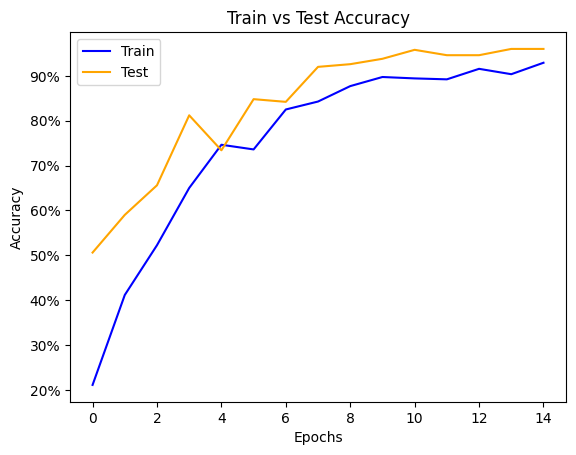

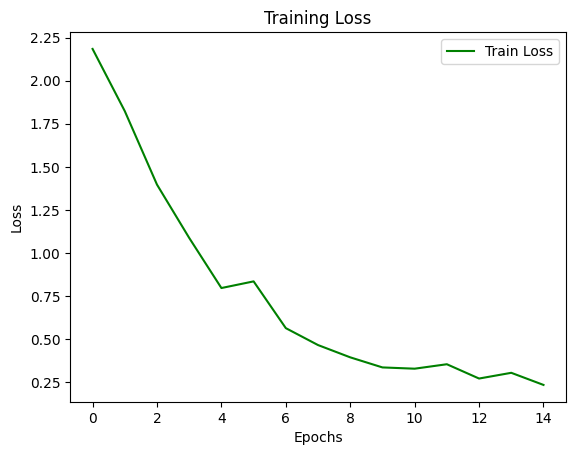

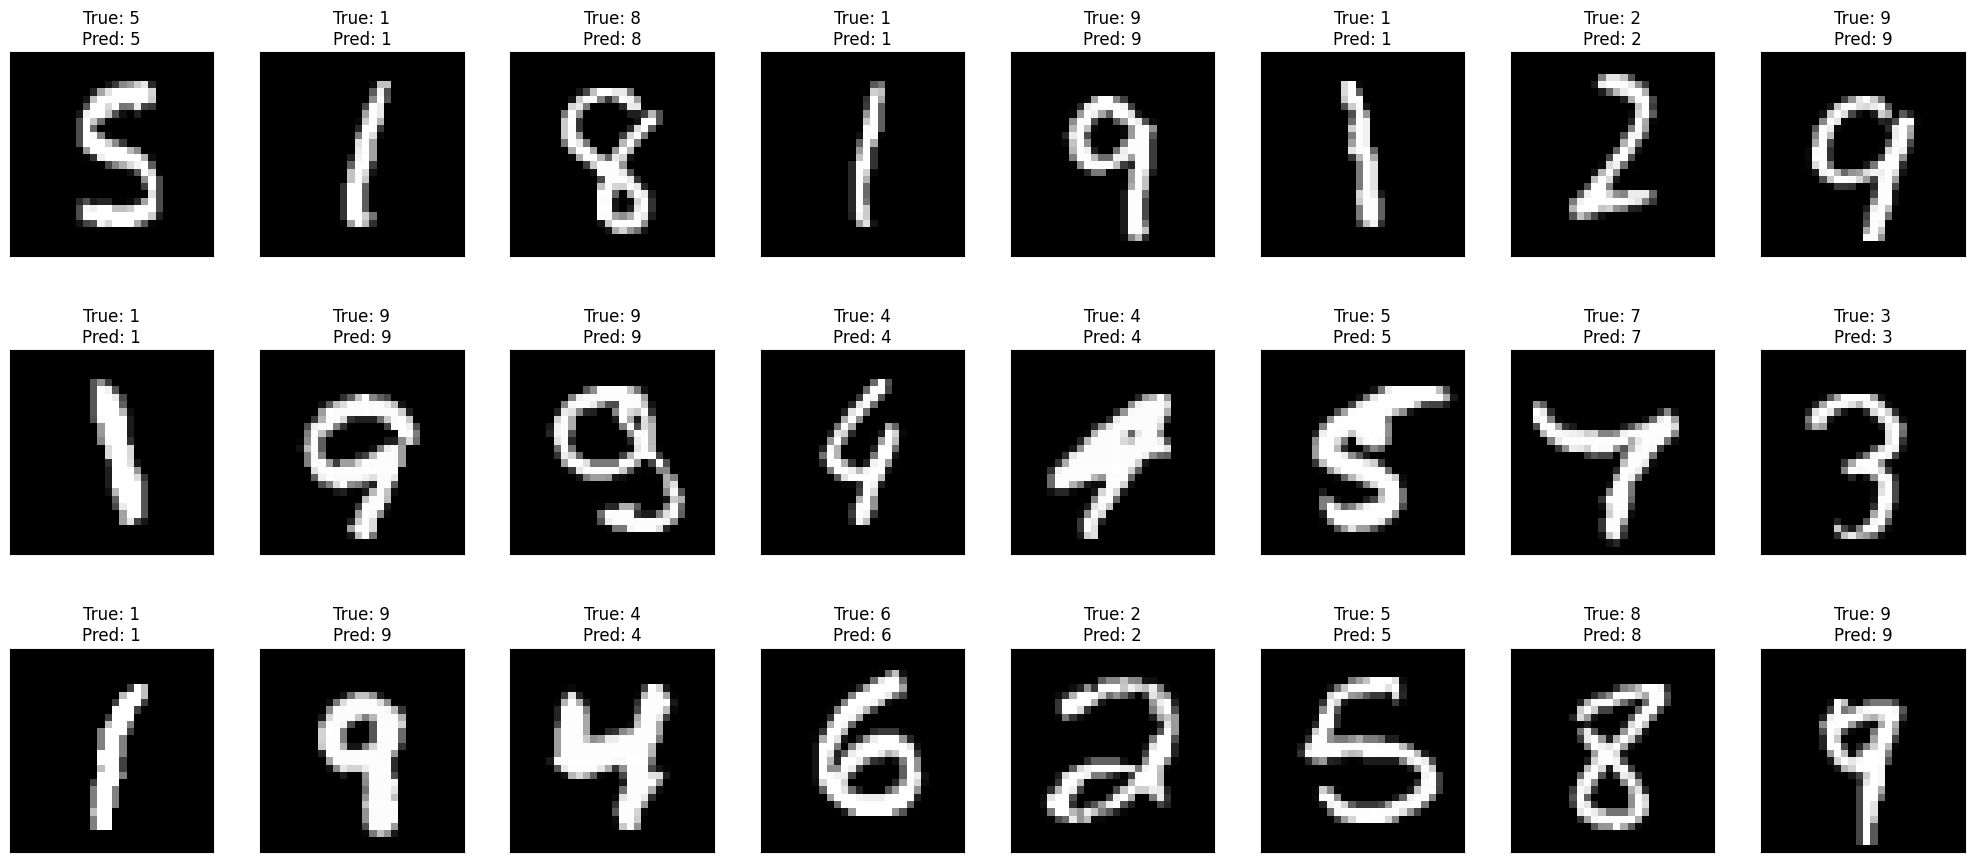

In [2]:
# ----------------------------
# Import libraries
# ----------------------------
import torch
from torch import nn, optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time

# ----------------------------
# Device setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------
# Hyperparameters
# ----------------------------
batch_size_train = 128
batch_size_test = 500
n_train = 2000
n_test = 500
learning_rate = 0.2
epochs = 15

# ----------------------------
# Data Augmentation and Transformations
# ----------------------------
train_transform = transforms.Compose([
    transforms.RandomRotation(10),       # rotate -10 to 10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # small shifts
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# ----------------------------
# Load Dataset
# ----------------------------
dataset_train = torchvision.datasets.MNIST("./files/", train=True, download=True, transform=train_transform)
dataset_train.data, dataset_train.targets = dataset_train.data[:n_train], dataset_train.targets[:n_train]

dataset_test = torchvision.datasets.MNIST("./files/", train=False, download=True, transform=test_transform)
dataset_test.data, dataset_test.targets = dataset_test.data[:n_test], dataset_test.targets[:n_test]

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False)

# ----------------------------
# Define CNN Model
# ----------------------------
model = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),  # Conv layer 1
    nn.ReLU(),
    nn.MaxPool2d(2, 2),              # Max pooling 1
    nn.Conv2d(16, 32, 3, padding=1), # Conv layer 2
    nn.ReLU(),
    nn.MaxPool2d(2, 2),              # Max pooling 2
    nn.Flatten(),                     # Flatten feature maps
    nn.Linear(32*7*7, 128),          # Fully connected
    nn.ReLU(),
    nn.Dropout(0.25),                 # Dropout for regularization
    nn.Linear(128, 10),               # Output layer
    nn.LogSoftmax(dim=1)              # Log softmax for NLLLoss
)
model = model.to(device)

# ----------------------------
# Loss and Optimizer
# ----------------------------
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# ----------------------------
# Accuracy function
# ----------------------------
def accuracy(ypred, y):
    pred = ypred.detach().argmax(1)
    return (pred == y).float().mean()

# ----------------------------
# Training function
# ----------------------------
def train_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(out, y).item()
    return total_loss / len(loader), total_acc / len(loader)

# ----------------------------
# Evaluation function
# ----------------------------
def evaluate(model, loader, device):
    model.eval()
    total_acc = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            total_acc += accuracy(out, y).item()
    return total_acc / len(loader)

# ----------------------------
# Training loop
# ----------------------------
train_accs, test_accs, losses, n_epochs = [], [], [], []

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, loss_function, optimizer, device)
    test_acc = evaluate(model, test_loader, device)
    
    train_accs.append(100*train_acc)
    test_accs.append(100*test_acc)
    losses.append(train_loss)
    n_epochs.append(epoch)
    
    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Train Acc: {100*train_acc:.2f}% | Test Acc: {100*test_acc:.2f}%")

# ----------------------------
# Plot Accuracy
# ----------------------------
plt.plot(n_epochs, train_accs, color='blue', label='Train')
plt.plot(n_epochs, test_accs, color='orange', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend()
plt.show()

# ----------------------------
# Plot Loss
# ----------------------------
plt.plot(n_epochs, losses, color='green', label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# ----------------------------
# Visualize predictions
# ----------------------------
def visualize_predictions(model, dataset, device, n_samples=24):
    v = torch.randint(0, len(dataset), (n_samples,))
    x_batch = dataset.data[v].float().unsqueeze(1).to(device)
    y_pred = model(x_batch).argmax(1)
    
    fig = plt.figure(figsize=(20,10))
    for i in range(n_samples):
        plt.subplot(3, 8, i+1)
        plt.tight_layout()
        plt.imshow(dataset.data[v[i]], cmap='gray', interpolation='none')
        plt.title(f'True: {dataset.targets[v[i]]}\nPred: {y_pred[i]}')
        plt.xticks([]); plt.yticks([])
    plt.show()

visualize_predictions(model, dataset_test, device)
